# Business Goal

Increase average order value (AOV) and overall revenue through effective product bundling and cross-sell strategies.

In [3]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!pip install -q kaggle
!kaggle datasets download -d carrie1/ecommerce-data

!unzip -q ecommerce-data.zip

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data
License(s): unknown
  0% 0.00/7.20M [00:00<?, ?B/s]
100% 7.20M/7.20M [00:00<00:00, 804MB/s]


In [1]:
# import data

import pandas as pd
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')

In [2]:
df.shape

(541909, 8)

# Step 1: Data Prep

In [3]:
# data cleaning

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative or zero quantities/prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Drop rows with missing Description
df.dropna(subset=['Description'], inplace=True)

# Clean Description text
df['Description'] = df['Description'].str.strip()

In [4]:
df.shape

(530104, 8)

# Step 2: Create Basket for Invoice

Each transaction (invoice) becomes a "basket" — a set of items purchased together.

In [5]:
# Filter for one country for clarity (e.g., UK)
df_uk = df[df['Country'] == 'United Kingdom']

# Step 1: Count item frequencies
item_counts = df_uk['Description'].value_counts()

In [8]:
item_counts.head(5)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2227
JUMBO BAG RED RETROSPOT,1957
REGENCY CAKESTAND 3 TIER,1710
PARTY BUNTING,1614
LUNCH BAG RED RETROSPOT,1421


In [9]:
# Step 2: Keep only top N items (e.g., 500)
top_items = item_counts[:500].index

# Step 3: Filter dataset
df_filtered = df_uk[df_uk['Description'].isin(top_items)]

In [13]:
df_filtered.shape

(245589, 8)

In [14]:
# creating basket

basket = (
    df_filtered
    .groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum().unstack().reset_index().fillna(0)
    .set_index('InvoiceNo')
)

# Convert to True/False instead of 0/1
basket = basket.astype(bool)

In [15]:
basket.shape

(16789, 500)

# Step 3: Market Basket Modeling

In [16]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)

# Then generate rules as before
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules.sort_values(by="lift", ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5808,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE GR...",(REGENCY TEA PLATE PINK),0.016737,0.015844,0.013283,0.793594,50.088928,1.0,0.013017,4.768068,0.996718,0.688272,0.790271,0.815970
5813,(REGENCY TEA PLATE PINK),"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE GR...",0.015844,0.016737,0.013283,0.838346,50.088928,1.0,0.013017,6.082510,0.995813,0.688272,0.835594,0.815970
5809,"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",(REGENCY TEA PLATE GREEN),0.014057,0.020013,0.013283,0.944915,47.214828,1.0,0.013001,17.790531,0.992775,0.638968,0.943790,0.804303
5812,(REGENCY TEA PLATE GREEN),"(REGENCY TEA PLATE ROSES, REGENCY TEA PLATE PINK)",0.020013,0.014057,0.013283,0.663690,47.214828,1.0,0.013001,2.931654,0.998809,0.638968,0.658896,0.804303
5805,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN),0.015844,0.020013,0.014355,0.906015,45.271091,1.0,0.014038,10.427061,0.993654,0.667590,0.904096,0.811638


In [20]:
rules.shape

(5980, 14)

#Step 4: Filter and Interpret Rules

In [17]:
filtered_rules = rules[
    (rules['lift'] > 1.2) &
    (rules['confidence'] > 0.4) &
    (rules['support'] > 0.02)
]

In [21]:
filtered_rules.shape

(163, 14)

In [23]:
filtered_rules.tail(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5656,(JUMBO BAG VINTAGE LEAF),(JUMBO BAG APPLES),0.048603,0.052713,0.020192,0.415441,7.881177,1.0,0.017630,1.620516,0.917720,0.248899,0.382913,0.399246
5704,(JUMBO BAG PEARS),(JUMBO BAG APPLES),0.032640,0.052713,0.022157,0.678832,12.877867,1.0,0.020437,2.949507,0.953469,0.350613,0.660960,0.549586
5705,(JUMBO BAG APPLES),(JUMBO BAG PEARS),0.052713,0.032640,0.022157,0.420339,12.877867,1.0,0.020437,1.668837,0.973673,0.350613,0.400780,0.549586
5832,(GARDENERS KNEELING PAD KEEP CALM),(GARDENERS KNEELING PAD CUP OF TEA),0.053487,0.044672,0.032223,0.602450,13.486042,1.0,0.029834,2.403038,0.978169,0.488708,0.583860,0.661892
5833,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.044672,0.053487,0.032223,0.721333,13.486042,1.0,0.029834,3.396576,0.969143,0.488708,0.705586,0.661892


# Step 5: Visualise Strong Rules

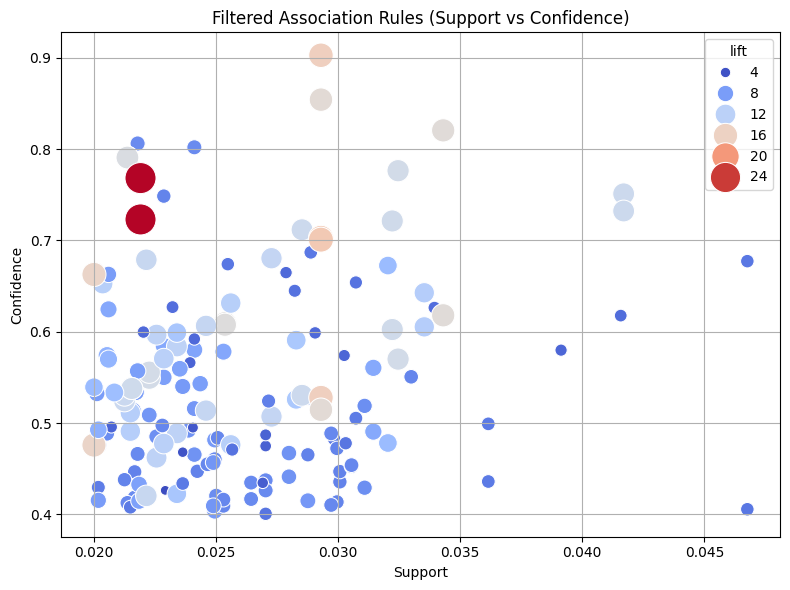

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=filtered_rules,
    x='support',
    y='confidence',
    size='lift',
    hue='lift',
    palette='coolwarm',
    sizes=(50, 500)
)
plt.title("Filtered Association Rules (Support vs Confidence)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True)
plt.tight_layout()


# Step 7: Simulate Revenue uplift

🔧 Assumptions:
1,000 customers are shown these combinations (through cart recommendation, email, or bundle offer).

Average product prices (assumed based on typical UK retail catalog prices):

JUMBO BAG items ≈ £2.00 each

GARDENERS KNEELING PAD ≈ £5.00 each

Revenue uplift = confidence × price of consequent × #customers exposed

In [24]:
import pandas as pd

# Your rules (summarized)
rules = pd.DataFrame({
    'antecedents': [
        'JUMBO BAG VINTAGE LEAF',
        'JUMBO BAG PEARS',
        'JUMBO BAG APPLES',
        'GARDENERS KNEELING PAD KEEP CALM',
        'GARDENERS KNEELING PAD CUP OF TEA'
    ],
    'consequents': [
        'JUMBO BAG APPLES',
        'JUMBO BAG APPLES',
        'JUMBO BAG PEARS',
        'GARDENERS KNEELING PAD CUP OF TEA',
        'GARDENERS KNEELING PAD KEEP CALM'
    ],
    'confidence': [0.415, 0.679, 0.420, 0.602, 0.721]
})

# Average prices
prices = {
    'JUMBO BAG APPLES': 2.00,
    'JUMBO BAG PEARS': 2.00,
    'GARDENERS KNEELING PAD CUP OF TEA': 5.00,
    'GARDENERS KNEELING PAD KEEP CALM': 5.00
}

# Simulate uplift (assume 1000 customers exposed per rule)
rules['consequent_price'] = rules['consequents'].map(prices)
rules['estimated_uplift_gbp'] = rules['confidence'] * rules['consequent_price'] * 1000

rules[['antecedents', 'consequents', 'confidence', 'estimated_uplift_gbp']]


,antecedents,consequents,confidence,estimated_uplift_gbp
0,JUMBO BAG VINTAGE LEAF,JUMBO BAG APPLES,0.415,830.0
1,JUMBO BAG PEARS,JUMBO BAG APPLES,0.679,1358.0
2,JUMBO BAG APPLES,JUMBO BAG PEARS,0.420,840.0
3,GARDENERS KNEELING PAD KEEP CALM,GARDENERS KNEELING PAD CUP OF TEA,0.602,3010.0
4,GARDENERS KNEELING PAD CUP OF TEA,GARDENERS KNEELING PAD KEEP CALM,0.721,3605.0


# Insights & Recommendations

---> JUMBO fruit-themed bags are often bought together. create 'FRUIT BAG BUNDLE' inclusing apples, pears and vintage leaf. Doing so could show an estimated monthly uplift of ~10k sterling.

---> Garden kneeling pads in “KEEP CALM” and “CUP OF TEA” styles are highly co-purchased. Promote these as a "Tea-Time Gardening Set" in newsletter or homepage banner. Doing so could show an estimated monthly uplift of approximately 30k sterling.

---> Reverse rules confirm mutual interest (cross-sell both ways). Implement dynamic product suggestion engine based on cart content. Doing so will provide long-term uplift.

# Scenario Planning

What happens if we offer a 10% discount on 'GARDENERS KNEELING PAD KEEP CALM'? Will this discount increase total revenue through higher sales and associated cross-sells?

🧠 Assumptions:

- Price of "KEEP CALM"	£5.00	(Base price)
- Discount Offered	10%	(New price = £4.50)
- Price of "CUP OF TEA"	£5.00	(Cross-sell item)
- Base volume sold	1,000 units	(Before discount)
- Price elasticity of demand	-1.5	(Industry norm: 1% price drop → 1.5% volume increase)
- Confidence (assoc. rule)	0.602	(Probability of cross-sell)

In [25]:
# Base values
original_price = 5.00
discount = 0.10
elasticity = -1.5
base_volume = 1000
confidence = 0.602
cross_sell_price = 5.00

# 1. New volume after discount
price_change_pct = -discount
volume_change_pct = elasticity * price_change_pct
new_volume = int(base_volume * (1 + volume_change_pct))  # e.g. 1000 * (1 + 0.15) = 1150

# 2. Revenue
base_revenue = base_volume * original_price
discounted_price = original_price * (1 - discount)
new_revenue = new_volume * discounted_price

# 3. Cross-sell impact
cross_sell_volume = new_volume * confidence
cross_sell_revenue = cross_sell_volume * cross_sell_price

# 4. Total Revenue Comparison
total_base_revenue = base_revenue
total_new_revenue = new_revenue + cross_sell_revenue

# 5. Profit simulation (assume 40% margin)
margin = 0.40
base_profit = total_base_revenue * margin
new_profit = total_new_revenue * margin

(base_revenue, new_revenue, cross_sell_revenue, total_new_revenue, base_profit, new_profit)

(5000.0, 5175.0, 3461.5, 8636.5, 2000.0, 3454.6000000000004)

# Results:

📈 Results
- Metric	--------------------- Before Discount ----	After Discount ---- Uplift
- Volume Sold -----------------	1,000	-------------------- 1,150	------------- +15%
- Revenue (Main Item)	---- £5,000 ----------------	£5,175 ------------	+£175
- Revenue (Cross-sell) ---------------------------------	£3,466 ------------	+£3,466
- Total Revenue	-------------- £5,000	---------------- £8,641	------------ +£3,641
-  Profit (@ 40%) -------------	£2,000 ----------------	£3,456 ------------	+£1,456


# Interpretation & Business Action:


- Yes, offering a 10% discount on “KEEP CALM” kneeling pad likely boosts overall profits significantly, due to:

- Increased base item sales (price elasticity). Strong cross-sell rule with "CUP OF TEA" variant

- This is a cross-sell driven revenue strategy, not just a pure discount tactic.

- Can be used in: Targeted email campaigns (to garden enthusiasts). Cart-based dynamic discounts. Bundle promotions

